In [1]:
import os
import cv2
import glob
import pickle
import numpy as np
import pylab as plt
import full_pipeline as fp
from IPython.display import Image

# This is deprecated: import Ipython.html.widgets instead:
import ipywidgets

%matplotlib inline

In [2]:
path2calib_im = "./camera_cal/"
path2test_im = "./test_images/"
pattern = "*.jpg"

In [3]:
camera_calibration = pickle.load(open(path2calib_im + "calibration_data.pkl", "rb" ))
perspective_matrix = pickle.load(open("./perspective_mat.pkl", "rb"))
M = perspective_matrix['M']
inv_M = perspective_matrix['inv_M']

test_images = glob.glob(path2test_im + pattern)

laboratory_rat_yellow = cv2.imread(test_images[1])
laboratory_rat_yellow = laboratory_rat_yellow[...,::-1]

laboratory_rat_white = cv2.imread(test_images[7])
laboratory_rat_white = laboratory_rat_white[...,[2, 1, 0]]

Following the pipeline defined in Pipline_part1.ipynb (copied here)

```python
# Let's define a function that carry on with all the steps

def pipeline(image, camera_calibration, perspective_matrix):
    
    # Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
    # Already done in Camera calibration.ipynb
    
    # Apply a distortion correction to raw images.
    undistorted = undistort(image, camera_calibration)
    
    # Use color transforms, gradients, etc., to create a thresholded binary image.
    thresholded = threshold(undistorted)
    
    # Apply a perspective transform to rectify binary image ("birds-eye view").
    birds_eye = perspective(thresholded, perspective_matrix)
    
    # Detect lane pixels and fit to find the lane boundary.
    detected_lanes, polynomials = detect_lanes(birds_eye)
    
    # Determine the curvature of the lane and vehicle position with respect to center.
    curvature = get_curvature(detected_lanes, polynomials)
    
    # Warp the detected lane boundaries back onto the original image.
    image_lanes = get_original_with_lanes()
    
    # Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
    final_image = visualization(image_lanes, curvature, vehicle_position)
    
    # TODO: where to get vehicle_position?
    
    return final_image
```

The first 4 points are done, now we need to continue with detect_lanes function

## Detect lane pixels and fit to find the lane boundary.

In [4]:
undistorted = fp.undistort(laboratory_rat_yellow, camera_calibration)
thresholded, _, _ = fp.threshold(undistorted)
birds_eye_yellow = fp.perspective(thresholded, M)

undistorted = fp.undistort(laboratory_rat_white, camera_calibration)
thresholded, _, _ = fp.threshold(undistorted)
birds_eye_white = fp.perspective(thresholded, M)

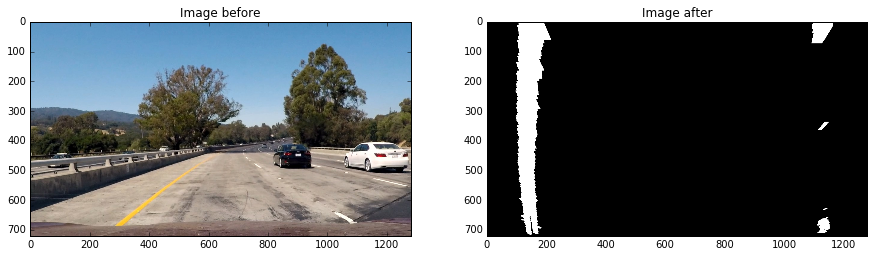

In [6]:
fp.visualize_before_after(laboratory_rat_yellow, birds_eye_yellow, cmap='gray')

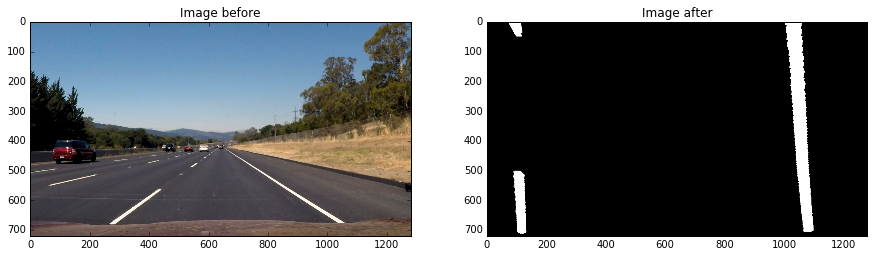

In [7]:
fp.visualize_before_after(laboratory_rat_white, birds_eye_white, cmap='gray')

In [ ]:
def detect_lanes(image, previous_position):
    
    if previous_position:
        origin = previous_position
    else:
        
    
    return detected_lanes, polynomials